In [1]:
import requests
import zipfile
import io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Source

United States Census Bureau. *Household Pulse Survey: Measuring Emergent Social and Economic Matters Facing U.S. Households*. https://www.census.gov/programs-surveys/household-pulse-survey.html

Fields JF, Hunter-Childs J, Tersine A, Sisson J, Parker E, Velkoff V, Logan C, and Shin H (2020). *Design and Operation of the 2020 Household Pulse Survey*. [https://www2.census.gov/programs-surveys/demo/technical-documentation/hhp/2020_HPS_Background.pdf]. U.S. Census Bureau.

The first citation is for the main Household Pulse Survey website. We are working with public use files at https://www.census.gov/programs-surveys/household-pulse-survey/data/datasets.html. The second citation is for a reference paper for understanding the larger context around the data we are working with.

I originally found an interesting COVID-19-related mental health dataset at https://catalog.data.gov/dataset/mental-health-care-in-the-last-4-weeks. That page points to a related Centers for Disease Control and Prevention (CDC) page at https://www.cdc.gov/nchs/covid19/pulse/mental-health-care.htm. Both of these are aggregated, but we will want disaggregated data for unsupervised learning. A link at the bottom of the CDC pages gets us back to the Census page and the original source(s), including disaggregated data.

## Survey and Survey Data Summary

I started this project by looking at candidate datasets. I came across the mental health dataset at https://catalog.data.gov/dataset/mental-health-care-in-the-last-4-weeks, I figured that data would be relatively straightforward to work with. Little did I know how just much complexity goes into surveys, survey data, and Census data. I will summarize what I learned about how the specific survey we look at in this project as well as how surveys similar to the one in this project work.

Note: much of my summary in this section comes from the main Household Pulse Survey link cited above as well as this sub-page: https://www.census.gov/data/experimental-data-products/household-pulse-survey.html

The United Stated Census Bureau is a primary hub for data about the American citizenry and economy. Before digging into this project, I was aware of the United States Census that happens every ten years. Beyond the official United States Census, I actually did not know what else the Census Bureau gathered, though I was aware that it was involved in other data work.

The Census Bureau started the Household Pulse Survey (HPS) in 2020 in partnership with other federal agencies and to measure the impact of the COVID-19 pandemic. The HPS gathers data about American households in a much faster timeframe than other surveys available at the time. The HPS originally surveyed respondents weekly. This then changed to bi-weekly and eventually monthly. Each of these collections is a cycle, and cycles get bundled into phases that typically run for around nine weeks with multiple collections during phases. From my research, this is a very fast turnaround time for surveys and survey data. One result of that is that representation among survey respondents becomes more difficult. We will speak about that more in the weighting section below. But, in general, it looks like the HPS has a gathering and reporting cycle that is pretty fast compared to many other common surveys that I looked into.

The HPS allows analysis at the national level, state level, and scoped to the 15 largest metropolitan statistical areas (MSA). You can find more information about MSAs at https://www.census.gov/programs-surveys/metro-micro.html, but my colloquial summary for them is areas of high population density and certain characteristics that make them population and economic hubs in their respective regions.

The HPS is a 20-minute survey that asks about demographic characteristics as well as a number of relevant topics such as:
- Childcare arrangements
- Food sufficiency
- Housing security
- Household spending
- Physical and mental health
- Health insurance coverage
- Social isolation
- (You can see a more complete list of topics at https://www.census.gov/data/experimental-data-products/household-pulse-survey.html in the section titled **What information does the Household Pulse Survey collect?**

The scope of what the HPS is looking to study is robust, and the topics are relevant to areas where people were struggling during the COVID-19 pandemic and are continuing to struggle now.

This project will focus on earlier surveys when the HPS started in 2020. The HPS continues today and has expanded in scope over time.

We will talk more about this below, but the general approach in this project will be to explore clustering, anomaly/outlier detection, and feature reduction. Each of these prefer or require disaggregated data. This means we will work with the HPS Public Use Files (PUF) instead of data tables. PUFs have respondent-level data. The Census Bureau provides data tables with re-weighting and aggregation already done so that researchers can focus on trends and findings instead of working on the disaggregated data, so those are available if of interest.

This is a quick summary of my current understanding of surveys, Census Bureau data, and the HPS. It took a lot of research to get to this level of understanding. I call this out because there is one more aspect of the HPS data that has been even more difficult to make sense of and to determine how to incorporate into this project: weighting.

## Survey Weights

Hold on to your hats. This section is going all over the place.

Determining what to do with the weights that come with the data has been the most difficult part of understanding the HPS data. Maybe the weightings are obvious to others, but I have spent more time trying to figure out what to do with these than any other research on the HPS and its data. It has been hard to find solid reference documentation on the right ways to use HPS weightings, and what I have found that is more concrete is for other Census Bureau data.

Okay. With that out of the way, here is my current understanding.

The three types of weights for the HPS are:
- Household weights: adjusts for household-level response representation that does not match known or expected representation for respondents based on the American Community Survey (ACS)
- Person weights: multiplies the household weight by the number of adults in the household to get per-person response values
- Replicate weights: provides 160 weights for use in estimating point estimates and associated variances and standard errors

There are references at the bottom of the notebook that describe Census Bureau weights. I find https://www2.census.gov/programs-surveys/demo/technical-documentation/hhp/2020_HPS_NR_Bias_Report-final.pdf to be the most useful, section 1.2 in particular. To get a sense of the complexity of these weights, see https://www.census.gov/content/dam/Census/library/publications/2010/acs/Chapter_11_RevisedDec2010.pdf. A number of the references I found are not for the HPS directly but help to understand how the Census Bureau uses weights for other surveys. Often that was the best I could find due to limited HPS-specific reference data for weighting.

The HPS uses demographic information from other Census Bureau sources to help adjust the data from the HPS, meaning we know from other sources what the demographic breakdown should look like, and we can adjust the HPS data so that it aligns with the representation that we see in other more reliable and established survey data. So, if we know that X% of the population in a response area are a certain race, we can adjust the HPS data to match that percentage even though we did not get that percentage based on actual responses. The reference papers mention that this process will still lead to inaccuracies, but it is preferable when trying to extrapolate to larger population-level findings. Remember also that the HPS was deployed to get faster feedback on American during the COVID-19 pandemic, so the trade-offs were acceptable.

Another confusing aspect is that some HPS data has individual household and person weights as single columns in the primary PUF while others only have person weights. Some have replicates for household and person weights separated out into 80 replicates each in different files, while some have them together -- I do not actually think having them in the same or separate files on its own is confusing, but, with the variety of presentation of weights, it adds one more piece to have to interpret. Some university resources I found have researchers dividing by weights while Census Bureau docs hint at multiplying by weights, the latter being what I would expect.

After reading through the supplementary resources, I am still not sure if the Census Bureau has one standard way to use weightings across all survey data or if there are nuances for each survey's use of weights. My sense is that the process for adjusting to individual-scale population data is the same across surveys, but the household piece does not show up as often. I wish the Census Bureau had released something concrete and straightforward for those of us not versed in using their weights.

Looking in more detail at the data, each row in the primary PUF is one household response. One adult per household responds on behalf of that household. We can use the household weights to adjust for representation purposes. When looking at population-level statistics, we need to adjust the household responses to represent individual people. We do this by multiplying the person weight by the number of adults in the household. Any adults who are not the respondent assume the respondent's demographic and other characteristics. This is known not to be fully accurate, but it is a best effort in trying to turn the data around quickly.

One item to bring up now is the distinction between clustering, dimensionality reduction, anomaly detection, and other unsupervised learning use cases compared to finding points estimates and associated variances, standard errors, and other measures for capturing uncertainty in those estimates. When working on point estimates, we use the replicate weights to simulate a much wider range of respondents and narrow in on more accurate calculations of uncertainty -- wider confidence intervals, as one example. This project will not focus on point estimates, so we can leave the replicate weights out.

Here is where I start to struggle with the best way forward for weights. The decision centers on if incorporating household or person weights will help with unsupervised learning. When we use weights, we adjust the values in each row, but we do not change the number of rows. When working with clustering, for example, adjusted feature values may change which cluster a row gets put in, but it does not increase the number of rows for underrepresented groups, so I am dubious about it revealing more accurate clusters, and I worry that it may actually make the situation worse by making it look like dissimilar household are actually part of the same cluster. If we were to take a strategy of replicating rows based on representation, then I could see new clusters starting to pop up around more groups. I will talk shortly about why I do not think we should pursue row resampling for the current project either.

One point to highlight from the last paragraph is that clustering, as one example, works against individual detailed rows, so it is doing something fundamentally different than point estimates. The point estimate tells us a summary piece of information about the population we are looking at. Clustering does provide us information in terms of optimal numbers of clusters, but I see it more as a step to understand groups in the data that we will later use as parts of larger analyses. One way we may use the trained clustering model is to pass in new HPS data to determine which group each row belongs to, possibly using clusters as a base unit for responses such as increased pandemic support.

Adjusting row values will change distances between rows for clustering, but it is not clear to me that that helps the situation for unsupervised learning. One worry is that by trying to incorporate weights when it is unclear if we should, we introduce a new problem on top of the original issue of underrepresentation. The burden should be on having a strong justification for adjusting with weights rather than the opposite. We know anyone working with the HPS data will need to determine how to understand the weights. We do not want to add an extra layer of confusion of adjusting with weights in arbitrary or incorrect ways that do not make a ton of sense and force others to have to untangle the reasoning there. 

Also, I still am not very clear on the correct way to apply the weights outside of some cases os using them for point estimation. It may be that I am leaning away from using the weights because I do not yet understand them enough, but, acknowledging that there is still confusion for me around them, I feel that the responsible decision is to leave the weights out for now. Future iterations of the project can incorporate them if and once ready.

If we leave the data at its original scale, one hypothesis I have is that we would be able to see underrepresented groups as outliers from clusters around overrepresented groups. Change feature values may actually end up muddying the situation enough that it becomes harder to see the distinction between the groups in the base data, or at the least not improve it.

If we do not adjust the data with weights, then it means we will cluster or look for anomalies at the household scale, unadjusted for representation. I am comfortable with this.

In summary, and in being honest, the proper way to incorporate weights still feels murky to me. This is a key area to get domain expertise help from someone who is fluent with working with Census Bureau weighting. But, for now, this is my best understanding of the weights and my reasoning for not incorporating them in the current project. So, we will move forward without adjusting based on household or person weights, and we already talked about why we will not use replicate weights. But this is one of the main areas to work on further or get help from others in future iterations.

## Project

There are lots of interesting questions to ask the HPS data related to impacts of the COVID-19 pandemic on American households. We will focus on exploring clustering patterns in demographic and financial factors during the first phase of the HPS and how adding in (food insecurity and/or housing insecurity and) health information affects those clusters. While we may not get to definite trends or policy recommendations in this project, we will set a foundation from which to more thoroughly pull information out of the HPS data in order to inform policy and practice that helps American household suffering from effects of the pandemic.

This project uses unsupervised machine learning mainly to explore clustering of HPS data. We will also experiment with dimensionality reduction to help identify high-impact features as well as possibly push into time-series cluster analysis.

As a reminder, each row in this dataset will be one household response given by a single adult in that household on behalf of everyone in that household, so the granularity we explore is at the household response level. As mentioned in the weight section, this is different from an aggregate household level (requires household weighting) or at the person level (requires additional person weighting).

There are lots of next steps from this project. One big area is iteration and repeating what we do here with other features in the HPS data, adding in more complexity to those analyses, and more. 

A second area is to pivot the work here further into supervised learning or decision-making points. This could look like using the current analyses to inform feature creation targeted at answering key question from the HPS data such as can we predict when households may move from food-secure to food-insecure. 

A third major follow-up would be to pivot into needs of domain experts. It is unlikely that the team that is most skilled in machine learning is also the team most knowledgeable about the specific data being studied, the larger research and trends in that data, and how to utilize that data to inform policy. While there needs to be constant collaboration between the machine learning team and domain experts, one goal of extended machine learning exploration should be to offer domain experts a better starting point from which to begin their level of policy recommendation work.

## Let's Get Some Data

We are going to focus on data from phase one of the HPS, running from the 23 April 2020 through 21 July 2020. The Census Bureau releases the data for each cycle as a compressed zip archive containing three files:
1. The PUF CSV data file
2. Replicate weights file
3. Data dictionary

We need to pull each of these zips, extract them, and combine the 12 PUFs. We do a little bit of column checking and dropping to make sure that the files line up correctly.

First is a code block that downloads the zip archives from the HPS website for when you need to grab the original archives.

In [2]:
# Sample URL
# 'https://www2.census.gov/programs-surveys/demo/datasets/hhp/2020/wk1/HPS_Week01_PUF_CSV.zip'

# Uncomment if you want to pull the source files from the Census Bureau website
# for i in range(1, 13):
#     r = requests.get(f'https://www2.census.gov/programs-surveys/demo/datasets/hhp/2020/wk{i}/HPS_Week{'0'+str(i) if i<10 else i}_PUF_CSV.zip')
#     if r.ok:
#         with zipfile.ZipFile(io.BytesIO(r.content), 'r') as zipz:
#             zipz.extractall('./data/')

In [3]:
df_01 = pd.read_csv('data/pulse2020_puf_01.csv')
df_02 = pd.read_csv('data/pulse2020_puf_02.csv')
df_03 = pd.read_csv('data/pulse2020_puf_03.csv')
df_04 = pd.read_csv('data/pulse2020_puf_04.csv')
df_05 = pd.read_csv('data/pulse2020_puf_05.csv')
df_06 = pd.read_csv('data/pulse2020_puf_06.csv')
df_07 = pd.read_csv('data/pulse2020_puf_07.csv')
df_08 = pd.read_csv('data/pulse2020_puf_08.csv')
df_09 = pd.read_csv('data/pulse2020_puf_09.csv')
df_10 = pd.read_csv('data/pulse2020_puf_10.csv')
df_11 = pd.read_csv('data/pulse2020_puf_11.csv')
df_12 = pd.read_csv('data/pulse2020_puf_12.csv')

Next we check out the columns. The first block shows that we have different numbers of columns across the 12 datasets. We also want to make sure that files with the same number of columns have the same column names. The second block tells us where we have different columns that we need to address. The third block combines all 12 datasets, dropping columns not present across all 12. This ensures that we are passing features that are present across all PUFs into the models later.

In [4]:
print(f'01: {len(df_01.columns)}')
print(f'02: {len(df_02.columns)}')
print(f'03: {len(df_03.columns)}')
print(f'04: {len(df_04.columns)}')
print(f'05: {len(df_05.columns)}')
print(f'06: {len(df_06.columns)}')
print(f'07: {len(df_07.columns)}')
print(f'08: {len(df_08.columns)}')
print(f'09: {len(df_09.columns)}')
print(f'10: {len(df_10.columns)}')
print(f'11: {len(df_11.columns)}')
print(f'12: {len(df_12.columns)}')

01: 82
02: 82
03: 82
04: 82
05: 82
06: 84
07: 105
08: 105
09: 105
10: 105
11: 105
12: 105


In [5]:
# Takes in two lists of columns and returns the columns in each set that are
# not present in the other, returning a null set for both when they have
# the same columns
def what_differences(cols1, cols2):

    # We need to check both directions separately since we are using difference()
    diff1 = set(cols1).difference(set(cols2))
    diff2 = set(cols2).difference(set(cols1))
    
    return diff1, diff2
    
print(f'01 02: {what_differences(df_01.columns, df_02.columns)}')
print(f'01 03: {what_differences(df_01.columns, df_03.columns)}')
print(f'01 04: {what_differences(df_01.columns, df_04.columns)}')
print(f'01 05: {what_differences(df_01.columns, df_05.columns)}')
print(f'01 06: {what_differences(df_01.columns, df_06.columns)}')
print(f'06 07: {what_differences(df_06.columns, df_07.columns)}')
print(f'07 08: {what_differences(df_07.columns, df_08.columns)}')
print(f'07 09: {what_differences(df_07.columns, df_09.columns)}')
print(f'07 10: {what_differences(df_07.columns, df_10.columns)}')
print(f'07 11: {what_differences(df_07.columns, df_11.columns)}')
print(f'07 12: {what_differences(df_07.columns, df_12.columns)}')

01 02: (set(), set())
01 03: (set(), set())
01 04: (set(), set())
01 05: (set(), set())
01 06: (set(), {'CHILDFOOD', 'TSTDY_HRS'})
06 07: (set(), {'SPNDSRC3', 'EIPSPND4', 'EIPSPND10', 'SPNDSRC2', 'SPNDSRC1', 'SPNDSRC4', 'EIPSPND8', 'EIPSPND5', 'EIPSPND6', 'SPNDSRC6', 'EIPSPND11', 'EIPSPND12', 'EIPSPND13', 'EIPSPND3', 'EIPSPND1', 'SPNDSRC7', 'EIPSPND2', 'EIPSPND9', 'EIPSPND7', 'SPNDSRC5', 'EIP'})
07 08: (set(), set())
07 09: (set(), set())
07 10: (set(), set())
07 11: (set(), set())
07 12: (set(), set())


In [6]:
df_combined = pd.concat([
    df_01
    , df_02
    , df_03
    , df_04
    , df_05
    , df_06.drop(columns=['TSTDY_HRS', 'CHILDFOOD'])
    , df_07.drop(columns=['TSTDY_HRS','CHILDFOOD','EIPSPND2','EIPSPND6','SPNDSRC1','EIPSPND4'
        ,'EIPSPND11','SPNDSRC2','EIPSPND10','SPNDSRC3','EIPSPND8','SPNDSRC6','EIPSPND13','EIPSPND12'
        ,'EIP','SPNDSRC4','EIPSPND9','EIPSPND1','SPNDSRC5','EIPSPND5','EIPSPND3','EIPSPND7','SPNDSRC7'
    ]), df_08.drop(columns=['TSTDY_HRS','CHILDFOOD','EIPSPND2','EIPSPND6','SPNDSRC1','EIPSPND4'
        ,'EIPSPND11','SPNDSRC2','EIPSPND10','SPNDSRC3','EIPSPND8','SPNDSRC6','EIPSPND13','EIPSPND12'
        ,'EIP','SPNDSRC4','EIPSPND9','EIPSPND1','SPNDSRC5','EIPSPND5','EIPSPND3','EIPSPND7','SPNDSRC7'
    ]), df_09.drop(columns=['TSTDY_HRS','CHILDFOOD','EIPSPND2','EIPSPND6','SPNDSRC1','EIPSPND4'
        ,'EIPSPND11','SPNDSRC2','EIPSPND10','SPNDSRC3','EIPSPND8','SPNDSRC6','EIPSPND13','EIPSPND12'
        ,'EIP','SPNDSRC4','EIPSPND9','EIPSPND1','SPNDSRC5','EIPSPND5','EIPSPND3','EIPSPND7','SPNDSRC7'
    ]), df_10.drop(columns=['TSTDY_HRS','CHILDFOOD','EIPSPND2','EIPSPND6','SPNDSRC1','EIPSPND4'
        ,'EIPSPND11','SPNDSRC2','EIPSPND10','SPNDSRC3','EIPSPND8','SPNDSRC6','EIPSPND13','EIPSPND12'
        ,'EIP','SPNDSRC4','EIPSPND9','EIPSPND1','SPNDSRC5','EIPSPND5','EIPSPND3','EIPSPND7','SPNDSRC7'
    ]), df_11.drop(columns=['TSTDY_HRS','CHILDFOOD','EIPSPND2','EIPSPND6','SPNDSRC1','EIPSPND4'
        ,'EIPSPND11','SPNDSRC2','EIPSPND10','SPNDSRC3','EIPSPND8','SPNDSRC6','EIPSPND13','EIPSPND12'
        ,'EIP','SPNDSRC4','EIPSPND9','EIPSPND1','SPNDSRC5','EIPSPND5','EIPSPND3','EIPSPND7','SPNDSRC7'
    ]), df_12.drop(columns=['TSTDY_HRS','CHILDFOOD','EIPSPND2','EIPSPND6','SPNDSRC1','EIPSPND4'
        ,'EIPSPND11','SPNDSRC2','EIPSPND10','SPNDSRC3','EIPSPND8','SPNDSRC6','EIPSPND13','EIPSPND12'
        ,'EIP','SPNDSRC4','EIPSPND9','EIPSPND1','SPNDSRC5','EIPSPND5','EIPSPND3','EIPSPND7','SPNDSRC7'
    ])
    ], ignore_index=True
)

print(what_differences(df_combined.columns, df_01))
print(df_combined.shape)

(set(), set())
(1088314, 82)


We now have one unified dataset with 1,088,314 rows and 82 columns. We will now pivot to the dictionary for the first cycle -- the first cycle because we removed any columns not present in the first cycle -- to determine what data we have available and what format it is in.

## Feature Summary

The survey asks 50 questions to recipients. First, here is a summary of the content of those question.

Demographic information:
- Birth year
- Gender
- Race/Ethnicity
- Educational attainment
- Marital status

Household information:
- Number of people in household
- Number of people under 18 in household
- Number of adults in household (calculated from previous two)

How you are doing (sample of questions asked in survey):
- Recent job loss in household
- Expected job loss in household
- Paid work in the past 7 days 
- Reason for not working
- Food sufficiency prior to 13 March 2020
- Food sufficiency for household in past 7 days
- Reason for insufficient food (choose all that apply):
    - Couldn't afford to buy more food
    - Couldn't get out to buy food
    - Afraid to or didn't want to go out
    - Couldn't get groceries or meals delivered
    - Stores didn't have wanted food
- Food sufficiency confidence in next 4 weeks
- General health status
- Frequency of anxiety, worry, little interest in things, or depression over past 7 days
- Health insurance coverage (choose all that apply):
    - Through current or former employer or union
    - Purchased directly through insurance company or marketplace
    - Medicare
    - Medicaid, Medical Assistance, or any other government-assistance plan for those with low income or a disability
    - TRICARE or other military healthcare
    - Veterans Affairs
    - Indian Health Service
    - Other
- Delayed medical care for something not related to pandemic
- Housing owned or rented
- Paid mortgage or rent on time last month
- Confidence in ability to pay mortgage or rent next month
- Children enrolled in school (choose all that apply, but options not listed here)
- Pandemic impact on education (choose all that apply, but options not listed here)
- Computer availability for educational purposes
- Provider of digital service (choose all that apply, but options not listed here)
- Internet available
- Internet service paid by (choose all that apply, but options not listed here)
- Total household income

Some of the questions in the last block are only shown for specific answers to other questions. For instance, the health insurance questions are shown to everyone, but the questions about where you received free groceries or meals depends on answering yes for the question about if you or anyone in your household has received free food in the past 7 days.

There are also a handful of features provided by researchers
- Allocation flags -- for some features such as birth year, gender, and race/ethnicity, if the respondent did not provide answers, then those missing values are filled in with hot-deck imputation
    - Hot-deck imputation is when you randomly sample a similar row and use its value for the feature with the missing value
- Estimated state for residency
- Estimated metropolitan statistical area for residency
- Week of interview

Some of the questions have values that are more informative than NULL:
- -99 - question seen but category not selected
- -88 - missing or did not report

### What Does It All Mean?

We see a wide range of questions related to how respondents are doing. We also see a few different question types with input in a range, multiple choice, and choose all that apply.

We may need a more nuanced way to handle missing values based on the explicit values for missing data combined with the fact that not everyone sees all questions. If we decide to go with something cruder, we can map both flags for missing values to 0s.

As discussed earlier, we want to avoid measures of central tendency or point estimation that goes beyond the granularity of household response since we are not incorporating weights. We will also want to avoid imputation based on measures of central tendency for the same logic around weights before. This should be fine since we can build models that expect unweighted input in future cycles and phases.

Most of the questions are categorical. Not sure if this is by design for reasons that survey researchers paid attention to. For our purposes, this means most of our preprocessing will be in determining if we need to remap any values or further encode any features. 

For nominal features where there is no inherent ordering in the answers, we should use one-hot encoding so that the models do not pick up on a directional relationship between the answers indicated by some values being higher or lower than others. We are not planning on testing out models that require non-singular matrices, so we should be fine using one-hot encoding instead of dummy encoding for nominal features.

For ordinal features, we will need to check that the current ordering for the answers is correct. If it is not, we may need to map to different values.

Another area we plan to explore is reducing the feature space. We can also explore principal component analysis (PCA) to let the PCA algorithm do this for us but with less interpretable results. One interesting approach we could try is to test out a model on the full dataset and on a dataset reduced by PCA.

## Preprocessing and Exploratory Data Analysis

We have a pretty big dataset to start out. Our first task is to reduce the feature space down to features that are relevant for this pass of the analysis. We also will need to encode all the categorical variables, so we need to trim the feature space down further so that the encoding step does not result in a dataset that is too wide and too sparse for reliable analysis and avoiding overfitting.

The following code block explicitly includes features related to demographics, financial status, and health. There are comments on each line for what information that feature holds.

In [7]:
df = df_combined.copy()[[
    # Demographic features
    'WEEK' # Week in phase
    , 'TBIRTH_YEAR' # Birth year of respondent
    , 'EGENDER' # Gender of respondent
    , 'RHISPANIC' # Is respondent Hispanic
    , 'RRACE' # Race of respondent
    , 'MS' # Marital status of respondent
    , 'THHLD_NUMPER' # Total number of people in household
    , 'THHLD_NUMKID' # Total number of kids in household
    , 'THHLD_NUMADLT' # Total number of adults in household
    # Financial status features
    , 'INCOME' # Total household income
    , 'TENURE' # HOUSING OWNED OR RENTED
    , 'MORTLMTH' # PAID LAST MONTH'S MORTGAGE OR RENT ON TIME
    , 'MORTCONF' # CONFIDENCE IN PAYING NEXT MONTH'S MORTGAGE OR RENT
    , 'WRKLOSS' # Did household have a recent job loss
    , 'EXPCTLOSS' # Does household expect a job loss -- may drop to remove questions asking about expectations
    , 'ANYWORK' # Employment status for past seven days
    , 'RSNNOWRK' # Main reason for not working for pay or profit -- may provide value-level preprocessing
    , 'UNEMPPAY' # Is respondent receiving pay for not working
    # Health features
    , 'HLTHSTATUS' # General health status
    , 'ANXIOUS' # Frequency of anxiety over past seven days
    , 'WORRY' # Frequency of worry over past seven days
    , 'INTEREST' # Frequency of lack of interest over past seven days
    , 'DOWN' # Frequency of feeling down over past seven days
    , 'HLTHINS1' # Health insurance through employer or union
    , 'HLTHINS2' # Health insurance through direct purchase
    , 'HLTHINS3' # Health insurance through Medicare
    , 'HLTHINS4' # Health insurance through Medicaid or other government assistance program
    , 'HLTHINS5' # Health insurance through TRICARE or other military program
    , 'HLTHINS6' # Health insurance through Veterans Affairs
    , 'HLTHINS7' # Health insurance through Indian Health Service
    , 'HLTHINS8' # Health insurance through other source
    , 'DELAY' # Delayed medical care in past four weeks due to pandemic
    , 'NOTGET' # Delayed medical care for something not related to pandemic
]]

print(f'The dataset has {df.shape[0]:,} rows and {df.shape[1]} columns\n')
print(df.dtypes.unique())
print(f'Feature space reduced down to {df.shape[1] / df_combined.shape[1]:.3f} of the original feature space')

The dataset has 1,088,314 rows and 33 columns

[dtype('int64')]
Feature space reduced down to 0.402 of the original feature space


We keep 40% of the original features, primarily excluding those related to food sufficiency, information about children and their education, allocation flags, and a couple of one-off features that do not seem like they will add to the analysis. We bucket the remaining features into the three we will work with in this project. The feature space will expand again once we encode the categorical features. We may decide to drop more of these features so that we do not end up with an encoded feature space that has ballooned to impractical size. But, first, we will take a look at the values within each feature.

To start out, we need to check for invalid values.

In [8]:
df.isnull().sum()

WEEK             0
TBIRTH_YEAR      0
EGENDER          0
RHISPANIC        0
RRACE            0
MS               0
THHLD_NUMPER     0
THHLD_NUMKID     0
THHLD_NUMADLT    0
INCOME           0
TENURE           0
MORTLMTH         0
MORTCONF         0
WRKLOSS          0
EXPCTLOSS        0
ANYWORK          0
RSNNOWRK         0
UNEMPPAY         0
HLTHSTATUS       0
ANXIOUS          0
WORRY            0
INTEREST         0
DOWN             0
HLTHINS1         0
HLTHINS2         0
HLTHINS3         0
HLTHINS4         0
HLTHINS5         0
HLTHINS6         0
HLTHINS7         0
HLTHINS8         0
DELAY            0
NOTGET           0
dtype: int64

In [9]:
for col in df:
    print(f'{col}: {np.sort(df_combined[col].unique()).tolist()}\n')

WEEK: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

TBIRTH_YEAR: [1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002]

EGENDER: [1, 2]

RHISPANIC: [1, 2]

RRACE: [1, 2, 3, 4]

MS: [-99, 1, 2, 3, 4, 5]

THHLD_NUMPER: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

THHLD_NUMKID: [0, 1, 2, 3, 4, 5]

THHLD_NUMADLT: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

INCOME: [-99, -88, 1, 2, 3, 4, 5, 6, 7, 8]

TENURE: [-99, -88, 1, 2, 3, 4]

MORTLMTH: [-99, -88, 1, 2, 3]

MORTCONF: [-99, -88, 1, 2, 3, 4, 5]

WRKLOSS: [-99, 1, 2]

EXPCTLOSS: [-99, 1, 2]

ANYWORK: [-99, 1, 2]

RSNNOWRK: [-99, -88, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

UNEMPPAY: [-99, -88, 1,

In [10]:
# Get rows with 13s compared to total rows in dataset
print(f'There are {df.loc[df['RSNNOWRK'] == 13, 'RSNNOWRK'].count():,} rows with value 13, '
      f'{df.loc[df['RSNNOWRK'] == 13, 'RSNNOWRK'].count() / df.shape[0]:.3f} of the total rows')

# Get total rows per week compared to rows with 13s per week
bad13 = pd.merge(
    df.loc[:,'WEEK'].value_counts().sort_index()
    , df.loc[df['RSNNOWRK'] == 13, 'WEEK'].value_counts().sort_index()
    , on='WEEK'
)
bad13.columns = ['total', '13s']
bad13['pct_diff'] = np.round(bad13['13s'] / bad13['total'], 3)
bad13

There are 9,374 rows with value 13, 0.009 of the total rows


,total,13s,pct_diff
WEEK,,,
6,83302,1090,0.013
7,73472,1007,0.014
8,108062,1531,0.014
9,98663,1458,0.015
10,90767,1454,0.016
11,91605,1479,0.016
12,86792,1355,0.016


In [11]:
# Get rid of the rows with 13s for RSNNOWRK
df.drop(df[df['RSNNOWRK'] == 13].index, inplace=True)
df.shape

(1078940, 33)

Fortunately, none of the features have null values. We assumed this due to the -99 and -88 replacement values for nulls. We need a strategy for how to handle those, possibly combining them along with other select factor levels into a catch-all missing flag.

The only value that looks out of range based on the data dictionary is the 13 for `RSNNOWRK`. This feature should have a range of 1:12 with -99 and -88 for missing values. None of the dictionaries for weeks 6-12 show a valid value of 13. The 13s account for around 1% of the total rows in the dataset and about 1-2% of the rows per week. Since there is no guidance on what the 13s are meant to indicate and since the 13s account for a small portion of rows, the safest approach is to drop them.

Next we will check out the -99 and -88 values. As a reminder from the dictionary:
- -99: Question seen but category not selected
- -88: Missing or did not report

In [12]:
# Prints out info about number of rows with -99 or -88 to compare how preprocessing steps are doing
def show_me_99_98():
    # Overall remaining row count
    print(f'There are {df.shape[0]:,} rows and {df.shape[1]:,} features remaining') 
    
    # Check how many rows have all of their values not equal to -99 and not equal to -88
    print(f'{df[df.ne(-99).all(1) & df.ne(-88).all(1)].shape[0]:,} rows do not have a -99 or -88, '
          f'{df[df.ne(-99).all(1) & df.ne(-88).all(1)].shape[0] / df.shape[0]:.3f} of the total dataset')

    # Count of -99s and -88s per feature
    gimme_99_88 = pd.concat([
        df[df == -99].count()
        , df[df == -88].count()
        ], axis=1
    )
    gimme_99_88.columns = ['-99', '-88']
    gimme_99_88['pct_-99'] = np.round(gimme_99_88['-99'] / df.shape[0], 3)
    gimme_99_88['pct_-88'] = np.round(gimme_99_88['-88'] / df.shape[0], 3)
    return gimme_99_88

In [13]:
show_me_99_98()

There are 1,078,940 rows and 33 features remaining
188,093 rows do not have a -99 or -88, 0.174 of the total dataset


,-99,-88,pct_-99,pct_-88
WEEK,0,0,0.000,0.000
TBIRTH_YEAR,0,0,0.000,0.000
EGENDER,0,0,0.000,0.000
RHISPANIC,0,0,0.000,0.000
RRACE,0,0,0.000,0.000
MS,8176,0,0.008,0.000
THHLD_NUMPER,0,0,0.000,0.000
THHLD_NUMKID,0,0,0.000,0.000
THHLD_NUMADLT,0,0,0.000,0.000
INCOME,22440,120746,0.021,0.112


So, what do we do with all of these -99s and -88s. They account for a large portion of the dataset. If we drop all the rows that have a -99 or -88, we lose 83% of the rows in the dataset. There are two crude approaches here:

1. Dropping 83% of the rows is way too many to lose. We can keep these rows in and likely combine both values into a 0 value to indicate missing for one reason or another. The downside of this approach is that we may have an overwhelming amount of 0s, and the models will overemphasize the 0s because of how prevalent they are. This issue likely will occur by leaving the -99s and -88s as they are too, even if we rescale them.
2. We can drop the rows. We are losing a huge amount of the rows in the dataset, and we already know that this data is messy because of the quick turnaround on the surveys, so we are losing much of the signals in the data. But, this approach means that the models have a greater chance of picking up on and prioritizing signals since they are no longer drowned out by the -99s and -88s.

We can also look at more sophisticated approaches.

The health insurance coverage questions look like the block of questions with the highest percentages of -99s and -88s. The dictionaries say that all respondents are shown all the health insurance coverage questions. Compared to other health questions such as `ANXIOUS` and `DOWN` that are also shown to all respondents, it seems more likely that respondents would select 'Yes' or 'No' for the latter two and only select one of the health insurance coverage questions to answer.

We can get around this by creating a new feature that has 1 for any rows that has a 1 in any of the health insurance features -- meaning the respondent did have some form of health insurance -- and 0 otherwise. We are mapping 2 to 1 and 1 to 0 from the original values, and we are coercing -99 and -88 into 0 to capture no indication of health insurance, remaining agnostic to the reason behind why we do not have a positive indicator of health insurance.



In [14]:
df_any_hlth_ins = df.copy().loc[:,'HLTHINS1':'HLTHINS8']
df_any_hlth_ins['has_hlth_ins'] = 0
df_any_hlth_ins.loc[df_any_hlth_ins[df_any_hlth_ins.eq(1).any(axis=1)].index, 'has_hlth_ins'] = 1 
# df_any_hlth_ins

df = pd.concat([
    df.drop(
        df.loc[:,'HLTHINS1':'HLTHINS8']
        , axis=1
    )
    , df_any_hlth_ins['has_hlth_ins']
    ], axis=1
)

show_me_99_98()

There are 1,078,940 rows and 26 features remaining
236,111 rows do not have a -99 or -88, 0.219 of the total dataset


,-99,-88,pct_-99,pct_-88
WEEK,0,0,0.000,0.000
TBIRTH_YEAR,0,0,0.000,0.000
EGENDER,0,0,0.000,0.000
RHISPANIC,0,0,0.000,0.000
RRACE,0,0,0.000,0.000
MS,8176,0,0.008,0.000
THHLD_NUMPER,0,0,0.000,0.000
THHLD_NUMKID,0,0,0.000,0.000
THHLD_NUMADLT,0,0,0.000,0.000
INCOME,22440,120746,0.021,0.112


Next we will take a look at `RSNNOWRK` and `UNEMPPAY`. 58% of rows have -88 for these features. 

According to the dictionaries, some subquestions only show up if a respondent selects a specific value for a previous question. For example, `RSNNOWRK` is only shown to respondents if they select 'no' (2) for `ANYWORK`, meaning they did not work in the past 7 days. In contrast, `UNEMPPAY` says 'TBD' (to be decided) for who gets shown that question, so it looks like it might be shown to all respondents, though the numbers hint that respondents who answer 'no' to `ANYWORK` also may not see `UNEMPPAY`.

The next code block shows that 625,677 respondents did not answer 'no' (2), so more than half of respondents do not even see `RSNNOWRK`. The same goes for `UNEMPPAY`. 

619,581 1s + 6,096 -99s = 625,677 respondents who did not select 2 for no work.


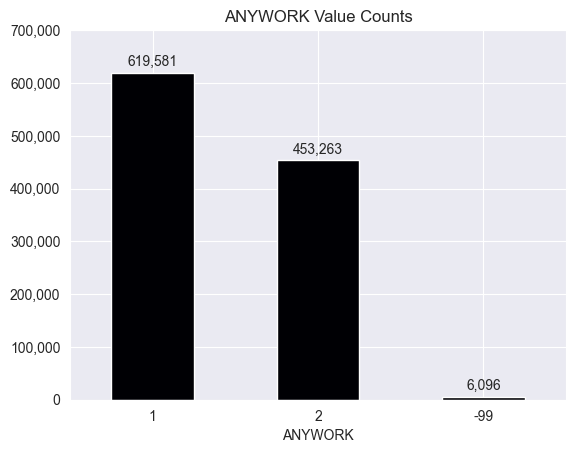

In [15]:
print(f'619,581 1s + 6,096 -99s = {619581 + 6096:,} respondents who did not select 2 for no work.')

ax = df['ANYWORK'].value_counts().plot(
    kind='bar'
    , title='ANYWORK Value Counts'
    , rot=0
    , xlabel=None
    , cmap='magma'
);
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);
# matplotlib throws a warning if you do not set the axis label values before then reformatting the labels,
# so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

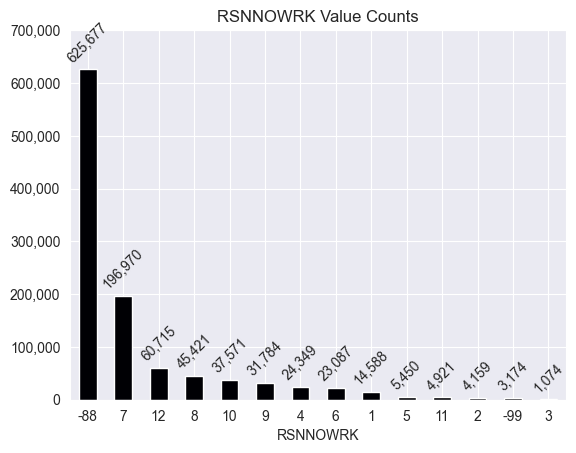

In [16]:
ax = df['RSNNOWRK'].value_counts().plot(
    kind='bar'
    , title='RSNNOWRK Value Counts'
    , rot=0
    , xlabel=None
    , cmap='magma'
);
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
    , rotation=45
);
# matplotlib throws a warning if you do not set the axis label values before then reformatting the labels,
# so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

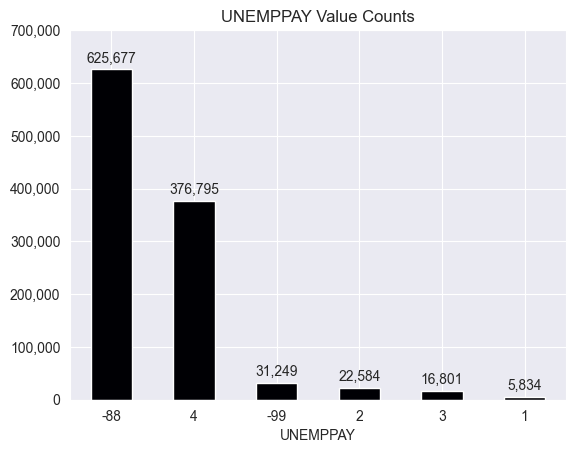

In [17]:
ax = df['UNEMPPAY'].value_counts().plot(
    kind='bar'
    , title='UNEMPPAY Value Counts'
    , rot=0
    , xlabel=None
    , cmap='magma'
);
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);
# matplotlib throws a warning if you do not set the axis label values before then reformatting the labels,
# so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


And to put them side-by-side by week.

In [18]:
df_no_work = pd.merge(
    pd.merge(
        df.loc[df['ANYWORK'] != 2, ['WEEK']].groupby('WEEK').value_counts()
        , df.loc[df['RSNNOWRK'] == -88, ['WEEK']].groupby('WEEK').value_counts()
        , on='WEEK'
    )
    , df.loc[df['UNEMPPAY'] == -88, ['WEEK']].groupby('WEEK').value_counts()
    , on='WEEK'
)
df_no_work.columns = ['ANYWORK', 'RSNNOWRK', 'UNEMPPAY']
df_no_work

,ANYWORK,RSNNOWRK,UNEMPPAY
WEEK,,,
1,42175,42175,42175
2,23146,23146,23146
3,77380,77380,77380
4,58027,58027,58027
5,60310,60310,60310
6,47891,47891,47891
7,42049,42049,42049
8,63208,63208,63208
9,56727,56727,56727


The amount of respondents not answering 'no' for `ANYWORK` and not seeing `RSNNOWRK` and `UNEMPPAY` match across the whole dataset as well as weekly, providing strong enough evidence for why those -88s are showing up. There is not a good way to handle the -88s in terms of imputation, and we do not want to lose over half of the rows by dropping rows with -88s, so a safer bet in this instance, though it does lose valuable features, is to drop `RSNNOWRK` and `UNEMPPAY`. They provide more nuance to the analysis, but we do still capture some of respondent's work situations by keeping `ANYWORK` in the dataset. We are also, at this point at least, still planning on keeping `WRKLOSS` and `EXPCTLOSS` to fill out questions related to work and questions around financial stability.

In [19]:
df.drop(columns=[
    'RSNNOWRK'
    , 'UNEMPPAY'
    ]
    , axis=1
    , inplace=True
)

show_me_99_98()

There are 1,078,940 rows and 24 features remaining
693,811 rows do not have a -99 or -88, 0.643 of the total dataset


,-99,-88,pct_-99,pct_-88
WEEK,0,0,0.000,0.000
TBIRTH_YEAR,0,0,0.000,0.000
EGENDER,0,0,0.000,0.000
RHISPANIC,0,0,0.000,0.000
RRACE,0,0,0.000,0.000
MS,8176,0,0.008,0.000
THHLD_NUMPER,0,0,0.000,0.000
THHLD_NUMKID,0,0,0.000,0.000
THHLD_NUMADLT,0,0,0.000,0.000
INCOME,22440,120746,0.021,0.112


Next we will take a look at the feature related to housing. There is a similar pattern to what we saw in the previous block about not working. Here, `TENURE` asks if someone owns or rents their housing. Two of the answers are for owned and paying on it (2) and renting and paying (3). When a respondent selects these options, they see `MORTLMTH` and `MORTCONF`, but respondents with other answers do not see the subquestions.

The following code blocks show slight discrepancies between how many non-responses we expect to see based on not selecting 2 or 3 for `TENURE` compared to how many show up as non-responses in the subquestions. It is not as clean as the previous block of questions we looked at, but it is close enough to show the same pattern.

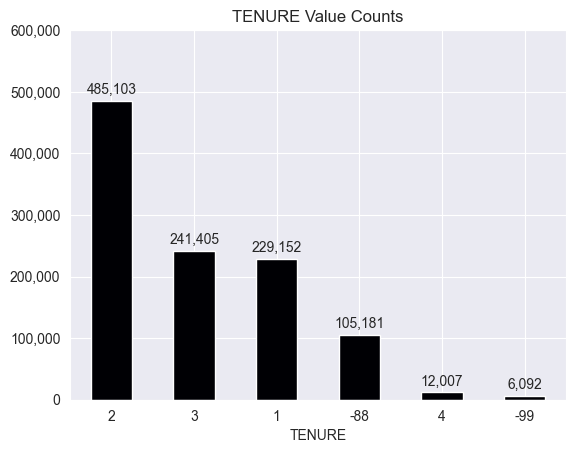

In [20]:
ax = df['TENURE'].value_counts().plot(
    kind='bar'
    , title='TENURE Value Counts'
    , rot=0
    , xlabel=None
    , cmap='magma'
);
ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=3
);
# matplotlib throws a warning if you do not set the axis label values before then reformatting the labels,
# so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);


In [21]:
df_pay_housing = pd.merge(
    pd.merge(
        df.loc[(df['TENURE'] != 2) & (df['TENURE'] != 3) , ['WEEK']].groupby('WEEK').value_counts()
        , df.loc[df['MORTLMTH'] == -88, ['WEEK']].groupby('WEEK').value_counts()
        , on='WEEK'
    )
    , df.loc[df['MORTCONF'] == -88, ['WEEK']].groupby('WEEK').value_counts()
    , on='WEEK'
)
df_pay_housing.columns = ['TENURE', 'MORTLMTH', 'MORTCONF']
df_pay_housing

,TENURE,MORTLMTH,MORTCONF
WEEK,,,
1,22268,22374,22374
2,13260,13306,13306
3,44628,44814,44814
4,35314,35475,35475
5,36459,36641,36641
6,28668,28816,28816
7,23256,23400,23400
8,33232,33441,33441
9,30887,31078,31078


In [22]:
df.drop(columns=[
    'TENURE'
    , 'MORTLMTH'
    , 'MORTCONF'
    ]
    , axis=1
    , inplace=True
)

show_me_99_98()

There are 1,078,940 rows and 21 features remaining
922,037 rows do not have a -99 or -88, 0.855 of the total dataset


,-99,-88,pct_-99,pct_-88
WEEK,0,0,0.000,0.000
TBIRTH_YEAR,0,0,0.000,0.000
EGENDER,0,0,0.000,0.000
RHISPANIC,0,0,0.000,0.000
RRACE,0,0,0.000,0.000
MS,8176,0,0.008,0.000
THHLD_NUMPER,0,0,0.000,0.000
THHLD_NUMKID,0,0,0.000,0.000
THHLD_NUMADLT,0,0,0.000,0.000
INCOME,22440,120746,0.021,0.112


The first item that stands out is that about a tenth of respondents did not answer `TENURE` (-88s + -99s). We also lose about 33% of the rows due to missing answers for the subquestions. If we drop the subquestions, all remaining rows are missing about 10%, and that feels much more reasonable to me in terms of how much data we drop before running analyses. I am also worried about imputing a third of the rows for the subquestions.

To add to the confusion about whether to keep the subquestions, the pandemic was a difficult time for housing costs. We saw housing costs balloon, and it is not clear how to account for that in this analysis. We saw government protections against evictions. We saw stimulus checks, and, while those would not offset recurring housing costs, they may have showed up in particular weeks, and it is unclear how to model for that.

All-in-all, I think it is easier to drop the two subquestions here. Unlike with the work questions above, I do not think we should keep the gatekeeper question this time since the distinction between owning and renting does not provide as much info about financial stability compared to the subquestions we are dropping. So, we drop all three of these features. 

At this point, we have a little over 920,000 rows out of the original 1.08 million rows, about 85%, with values other than -99 and -88. We are getting closer to a clean enough and dense enough -- after encoding -- dataset for modeling. The remaining features have a little under or over 10% of their rows as -88s. We will see if we can clean those up further to keep more of the dataset for modeling.

`INCOME` is a singular feature that does not have subquestions or other main questions with it, so we will likely end up dropping rows with -99s or -88s for this feature.

The remaining questions are related to respondents' health. We have what looks like two blocks of questions based on matching numbers of -88s. All seven of these questions are shown to all respondents.

First, we need to make sure the numbers match across weeks to confirm that there is not a whole week missing or something along those lines.

In [63]:
def return_health_df(df_input, col_input):
    df_temp = pd.DataFrame(
        df_input.loc[df_input[col_input] == -88, ['WEEK']].groupby('WEEK').value_counts()
    )
    df_temp.columns=[col_input]
    return df_temp

pd.concat([
    return_health_df(df, 'HLTHSTATUS')
    , return_health_df(df, 'ANXIOUS')
    , return_health_df(df, 'WORRY')
    , return_health_df(df, 'INTEREST')
    , return_health_df(df, 'DOWN')
    , return_health_df(df, 'DELAY')
    , return_health_df(df, 'NOTGET')
    ]
    , axis=1
)

,HLTHSTATUS,ANXIOUS,WORRY,INTEREST,DOWN,DELAY,NOTGET
WEEK,,,,,,,
1,5097,5097,5097,5097,5097,5710,5710
2,2549,2549,2549,2549,2549,2809,2809
3,13064,13064,13064,13064,13064,14534,14534
4,10417,10417,10417,10417,10417,11556,11556
5,10737,10737,10737,10737,10737,11950,11950
6,7868,7868,7868,7868,7868,8831,8831
7,5071,5071,5071,5071,5071,5930,5930
8,8014,8014,8014,8014,8014,9291,9291
9,7278,7278,7278,7278,7278,8429,8429


We see the two blocks of questions based on matching amounts. It looks like the same number of respondents are missing answers within each block. This seems strange to me. The dictionary indicates that all seven of these questions were shown to all respondents. I would expect to see differences for missing values across each feature for each week. The fact that there is some sort of consistency across features may hint something like not all respondents actually seeing each of the questions. We could go back to the base dataset and see if, for example, we can find a value in another feature that sums to 5,097 in week one, hoping that we would be able to determine why the 5,097 respondents did not answer for the first five health questions here during that week.

That all said, we want to keep these features in the modeling dataset so that we do not lose most of our health information, health being the secondary focus of analysis. So, we will accept the losses and drop any remaining rows with missing values. We will still keep a little under a million of the original rows, about 85% of what we started with.

In [77]:
df.drop(
    df[
        ~(df.ne(-99).all(1) & 
          df.ne(-88).all(1))
    ].index
    , inplace=True
)

show_me_99_98()

Next, we will explore the data that remains for modeling.



## References

Household Pulse Survey technical documentation: 
- https://www.census.gov/programs-surveys/household-pulse-survey/technical-documentation.html

Household Pulse Survey page with example usages:
- https://www.census.gov/programs-surveys/household-pulse-survey/library/working-papers.html

Info about survey weights:
- https://www.pewresearch.org/methods/2018/01/26/how-different-weighting-methods-work/
- https://pages.nyu.edu/jackson/design.of.social.research/Readings/Johnson%20-%20Introduction%20to%20survey%20weights%20%28PRI%20version%29.pdf
- https://analythical.com/blog/weighting-data-explained

Replicate weights for the Census Current Population Survey (CPS):
- https://cps.ipums.org/cps/repwt.shtml

Decision tree for using Census Bureau Survey of Income and Program Participation (SIPP) weights:
- https://www2.census.gov/programs-surveys/sipp/Select_approp_wgt_2014SIPPpanel.pdf
 
R example of working with CPS data and replicate weights:
- https://www.adambibler.com/post/exploring-census-household-pulse-survey-part-1/

Articles about using CPS data and weights:
- https://www.jchs.harvard.edu/blog/using-the-census-bureaus-household-pulse-survey-to-assess-the-economic-impacts-of-covid-19-on-americas-households
- https://www.bgsu.edu/content/dam/BGSU/college-of-arts-and-sciences/center-for-family-and-demographic-research/documents/Workshops/2020-Household-Pulse-Survey.pdf

Put in links to where to find supplementary PDFs for HPS and Census data
- https://www2.census.gov/programs-surveys/demo/technical-documentation/hhp/2020_HPS_Background.pdf
- https://www2.census.gov/programs-surveys/demo/technical-documentation/hhp/2020_HPS_NR_Bias_Report-final.pdf
- https://www.census.gov/content/dam/Census/library/publications/2010/acs/Chapter_11_RevisedDec2010.pdf
- https://www.census.gov/content/dam/Census/programs-surveys/ahs/tech-documentation/2015/Quick_Guide_to_Estimating_Variance_Using_Replicate_Weights_2009_to_Current.pdf
- https://www2.census.gov/programs-surveys/cps/datasets/2018/supp/PERSON-level_Use_of_the_Public_Use_Replicate_Weight_File.doc
- https://www2.census.gov/programs-surveys/cps/datasets/2021/march/Guidance_on_Using_Replicate_Weights_2020-2021.pdf

Video presentations that include chunks about the HPS or other Census data: 
- https://www.youtube.com/watch?v=ltyT34S3C90
- https://www.youtube.com/watch?v=lLk6esuBI6M
- https://www.youtube.com/watch?v=aJDQmsmCv7A
- https://www.youtube.com/watch?v=zfXohiWjzzY
- https://www.youtube.com/watch?v=5Re4D1Ht74k